# LiDAR FRC Field Position Calculations

This is a notebook that displays how to use Lidar points to align a robot to an FRC Field to produce a position and heading on the field.


In [1]:
import cv2
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from math import sin, cos, atan2, pi

sys.path.insert(0, os.path.abspath('../'))
sys.path.insert(0, os.path.abspath('./'))

from icp import icp_svd, center_data, get_correspondence_indices, compute_cross_covariance
from chart import draw_correspondences, plot_data, plot_values, animate_results, show_map_image
from map import load_frc2019_field, Robot

plt.rcParams["figure.figsize"]=30,30

### LiDAR Map

This is where we set up the LiDAR Map examples to test them. First, is the FRC2019 field itself.

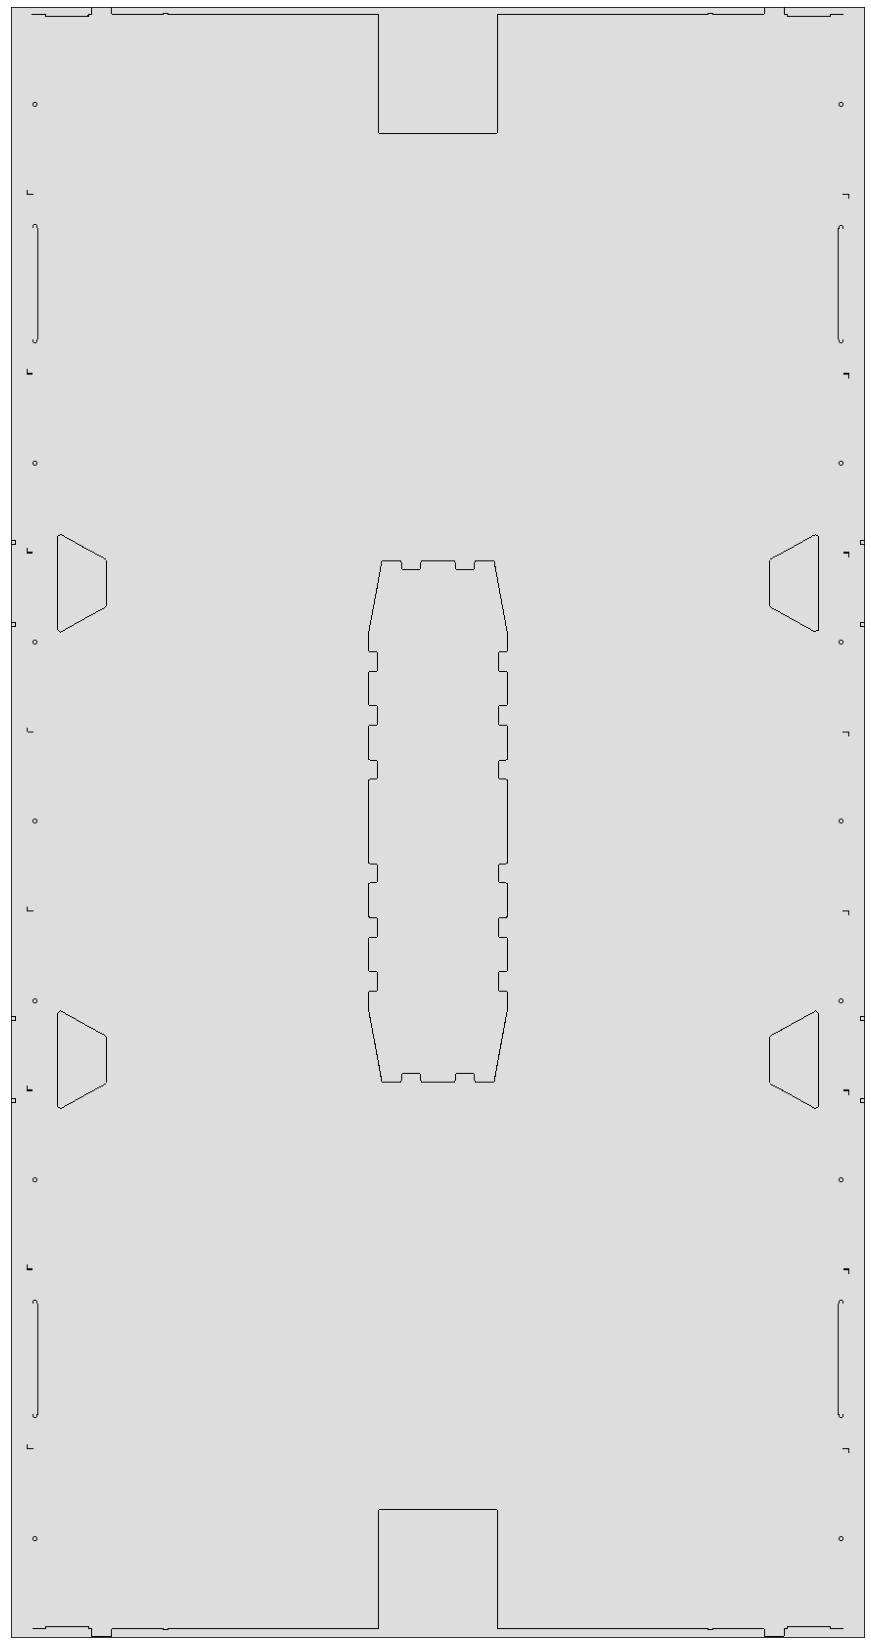

In [2]:
frc2019_field = load_frc2019_field()

show_map_image(np.asarray(frc2019_field.image))

#### Robot Position on Map

Adding a Robot object onto the map allows us to track position and visualize it

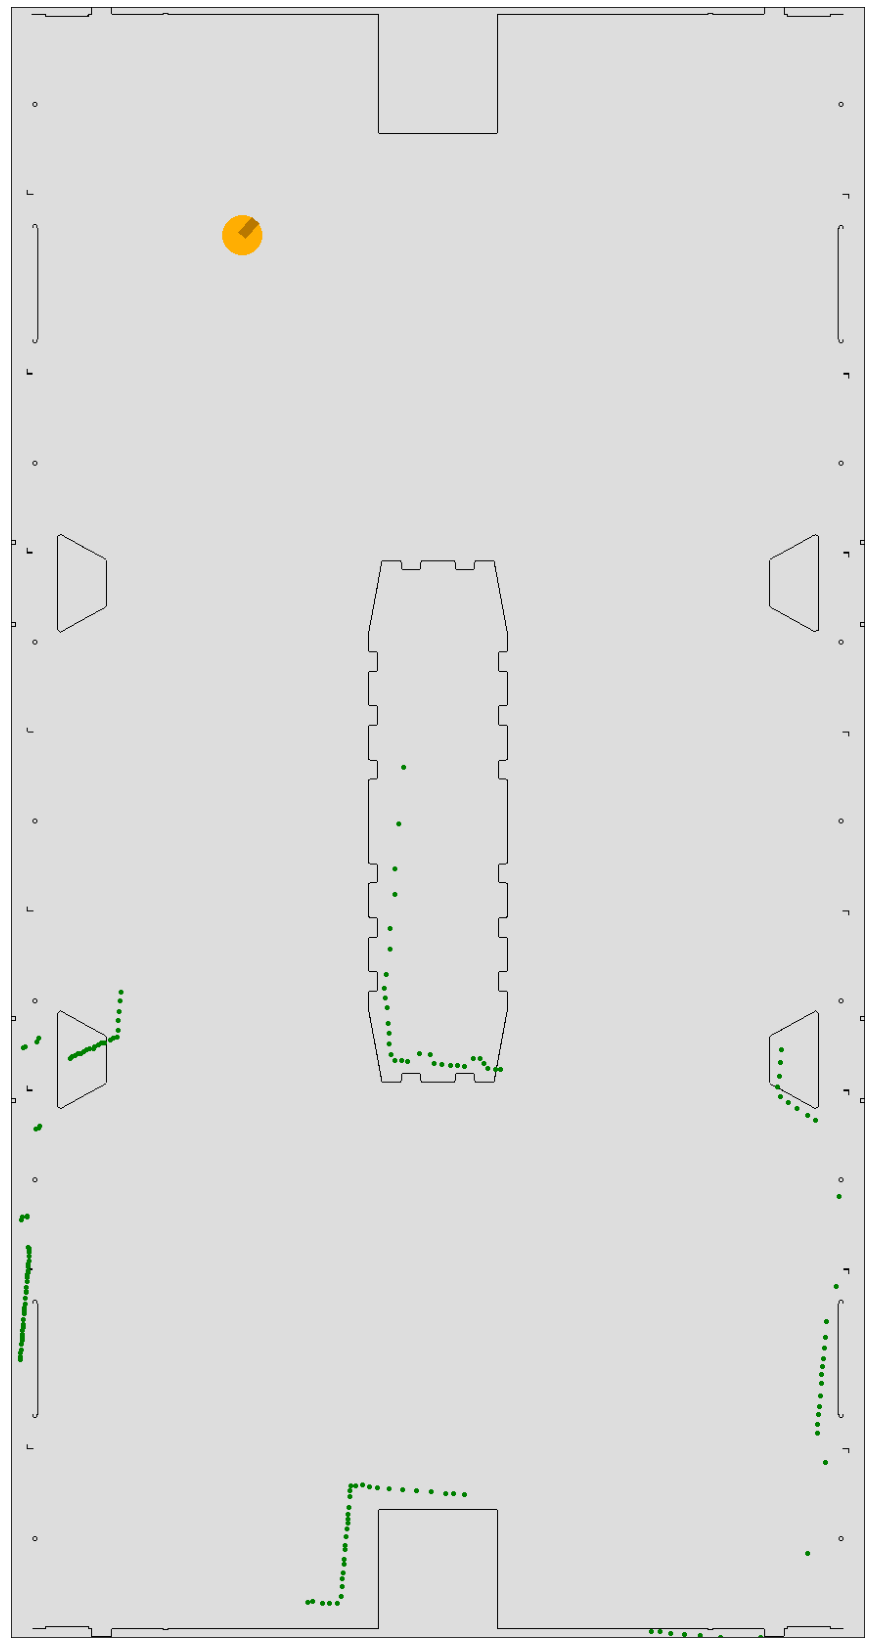

In [3]:
robot = Robot()

robot.set_position(-2000.0, -6000.0, 45.0)
robot.load_scan_file('FRC2019 LiDAR 10cm s 5 deg ccw.png.point')

show_map_image(np.asarray(frc2019_field.draw_map_with_robot(robot)))

#### Display Local Map relative to Robot

This is useful for more close-up visual work

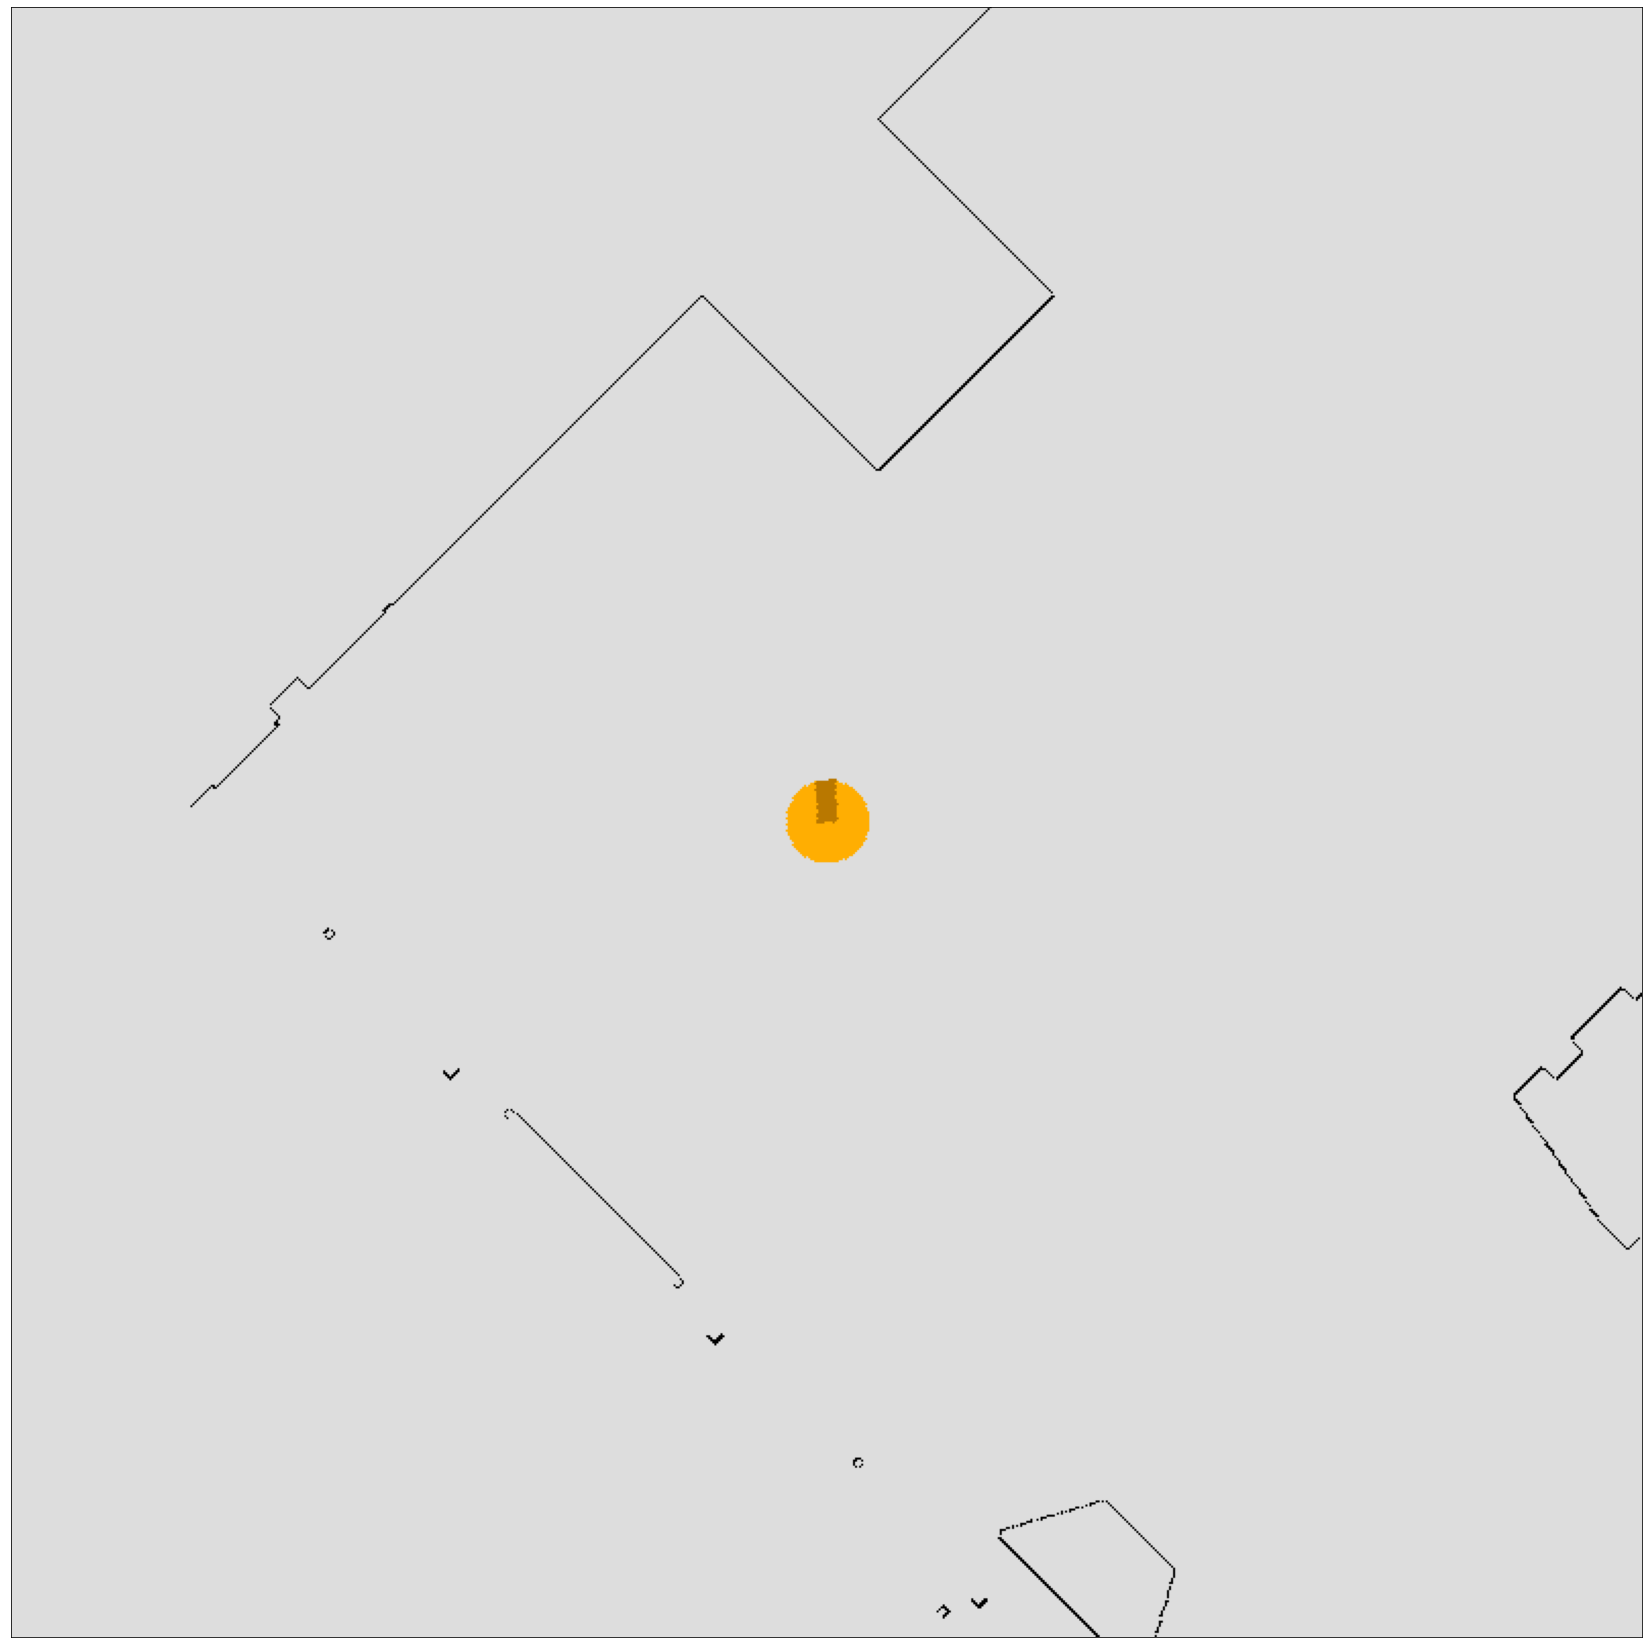

In [4]:
show_map_image(np.asarray(frc2019_field.draw_local_map(robot, 4000)))

#### Use the icp algorithm on the map and ping data points

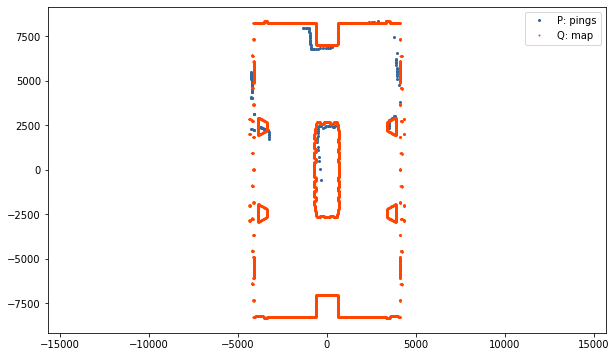

In [5]:
Q = frc2019_field.wall_points
P = robot.ping_points

plot_data(P, Q, "P: pings", "Q: map", markersize_1=2, markersize_2=1)
plt.show()

### Calculate correspondences

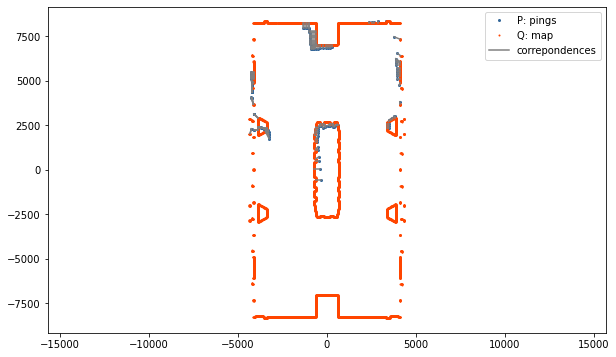

In [6]:
correspondences = get_correspondence_indices(P, Q)
ax = plot_data(P, Q, "P: pings", "Q: map", markersize_1=2, markersize_2=1)
draw_correspondences(P, Q, correspondences, ax)
plt.show()

### Compute Cross Covariance

In [7]:
cov, _ = compute_cross_covariance(P, Q, correspondences)
print(cov)

[[ 1.4679547e+09 -5.1219920e+08]
 [-5.8744530e+08  4.0034126e+09]]


### Find $R$ and $t$ from SVD decomposition
Here we find SVD decomposition of the cross covariance matrix and apply the rotation to $Q$

In [8]:
x_offsets = []
y_offsets = []

for index in range(0, len(correspondences)):
    p_index = correspondences[index][0]
    q_index = correspondences[index][1]
    
    p_x = P[0][p_index]
    p_y = P[1][p_index]
    q_x = Q[0][q_index]
    q_y = Q[1][q_index]
    
    x_offset = q_x - p_x
    y_offset = q_y - p_y
    
    x_offsets.append(x_offset)
    y_offsets.append(y_offset)

x_offsets.sort()
y_offsets.sort()

t_found = [[x_offsets[int(len(correspondences)/2)]], [y_offsets[int(len(correspondences)/2)]]]
    
U, S, V_T = np.linalg.svd(cov)
print(S)
R_found = U.dot(V_T)
#t_found = center_of_Q - R_found.dot(center_of_P)
print("R_found =\n", R_found)
print("t_found =\n", t_found)

[4.11776766e+09 1.35411703e+09]
R_found =
 [[ 0.99990544  0.0137514 ]
 [-0.0137514   0.99990544]]
t_found =
 [[20.0], [0.0]]


### Apply a single correction to $P$ and visualize the result
This is the result after just one iteration. Because our correspondences are not optimal, it is not a complete match.

[[20.0], [0.0]]
[[ 0.99990544  0.0137514 ]
 [-0.0137514   0.99990544]]


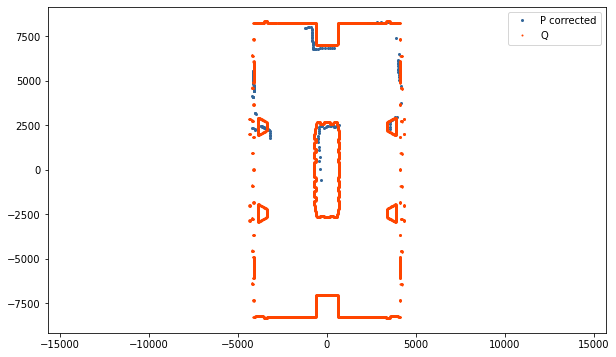

In [9]:
print(t_found)
print(R_found)
P_corrected = R_found.dot(P) + t_found
ax = plot_data(P_corrected, Q, label_1='P corrected', label_2='Q', markersize_1=2, markersize_2=1)
plt.show()

### Iterative Example

In [ ]:
P_values, corresp_values = icp_svd(P, Q, iterations=20)
ax = plot_data(P_values[-1], Q, label_1='P final', label_2='Q', markersize_1=2, markersize_2=1)
plt.show()

sums: 8960.0,4730.0
mean offset: 56.0,29.5625
sums: -135.0345979036171,3318.9238261563532
mean offset: -0.843966236897607,20.743273913477207
sums: -2430.4867113129226,4966.272945349579
mean offset: -15.190541945705766,31.039205908434866
sums: -3117.260512295789,5643.0449293525635
mean offset: -19.48287820184868,35.26903080845352
sums: -3643.7333015013774,5704.5400280788135
mean offset: -22.77333313438361,35.653375175492585
sums: -3235.5654519200993,3444.7575968590036
mean offset: -20.22228407450062,21.529734980368772
sums: -2880.053638673704,2047.3903930521467
mean offset: -18.00033524171065,12.796189956575917
sums: -2590.490466888253,1702.1221683398294
mean offset: -16.190565418051584,10.638263552123934
sums: -2804.1699380785108,1195.27919611125
mean offset: -17.526062112990694,7.4704949756953125
sums: -2687.9225204691606,939.8677421702066
mean offset: -16.799515752932255,5.874173388563792
sums: -2455.8122554850897,1043.1146981676206
mean offset: -15.34882659678181,6.519466863547629
s

In [ ]:
animate_results(P_values, Q, correspondences, corresp_values, xlim=(-6000, 6000), ylim=(-10000, 10000))